# **Information Retrieval and Web Analysis (IRWA)**
## **Final Project - G014**

Paula Ceprián (u198630)

Judit Viladecans (u198724)

Berta Noguera (u199893)

This notebook is part of the **Information Retrieval and Web Analytics (IRWA) project**, which aims to build a **Retrieval-Augmented Generation (RAG) system** supported by a custom search engine. The notebook will cover Parts 1, 2, and 3 of the project:
- **Part 1** involves text processing and exploratory data analysis (EDA) to understand and prepare the dataset through cleaning and word exploration.
- **Part 2** focuses on indexing and evaluation, implementing efficient data structures and metrics to assess retrieval performance.
- **Part 3** addresses ranking and filtering, applying algorithms to improve the relevance and quality of retrieved results.

Currently, this notebook includes Part 1 of the project, and it will be extended with the following parts as the course progresses.

## **Import Basic Libraries and Datasets**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# if you do not have 'nltk', the following command should work "python -m pip install nltk"
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from numpy import linalg as la
from wordcloud import WordCloud

import re
import math
import spacy
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Berta's fashion path: /content/drive/MyDrive/5è curs/Labs IRWA/IRWA Labs/PART 1 Final Project/fashion_products_dataset.json
# Berta's validation path: /content/drive/MyDrive/5è curs/Labs IRWA/IRWA Labs/PART 1 Final Project/validation_labels.csv
# Paula's fashion path: /content/drive/MyDrive/Quinto/IRWA/IRWA Labs/PART 1 Final Project/fashion_products_dataset.json
# Paula's validation path: /content/drive/MyDrive/Quinto/IRWA/IRWA Labs/PART 1 Final Project/validation_labels.csv
# Judit's fashion path: /content/drive/MyDrive/5è CURS/IRWA/IRWA Labs/PART 1 Final Project/fashion_products_dataset.json
# Judit's validation path: /content/drive/MyDrive/5è CURS/IRWA/IRWA Labs/PART 1 Final Project/validation_labels.csv

fashion_path = "/content/drive/MyDrive/5è CURS/IRWA/IRWA Labs/PART 1 Final Project/fashion_products_dataset.json"
fashion_df = pd.read_json(fashion_path)

validation_path = "/content/drive/MyDrive/5è CURS/IRWA/IRWA Labs/PART 1 Final Project/validation_labels.csv"
val_df = pd.read_csv(validation_path)

## **Part 1: Text Processing and Exploratory Data Analysis**

### **1. Data preparation**

We must pre-process the documents. In particular, for the text fields we should:
- Remove stop words and punctuation marks
- Do tokenization and stemming

We must take into account that for future queries, the final output will return the following information for each of the selected documents: `pid`, `title`, `description`, `brand`, `category`, `sub_category`, `product_details`, `seller`, `out_of_stock`, `selling_price`, `discount`, `actual_price`, `average_rating`, `url`.

In [5]:
# Function to process each product registered by eliminating stop words and punctuation marks, as well as doing stemming and tokenization
def build_terms(line):
    """
    Preprocess the specific text related to an article by removing stop words, stemming,
    transforming in lowercase, removing punctuation and return the tokens of the text.

    Argument:
    line -- string (text) to be preprocessed

    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    line=  line.lower()  # Transform in lowercase
    line= re.sub(r'[^\w\s]', '', line)  # Remove punctuation
    line= re.sub(r'[0-9]', '', line)  # Remove numbers
    line =  line.split()
    line= [word for word in line if word not in stop_words]  # Eliminate the stopwords
    line= [stemmer.stem(word) for word in line]  # Perform stemming

    return line

In [6]:
# Function to process the "product details" of the articles
def flatten_product_details(details):
    """
    Preprocess the text in "product details" and store it as a unique text.

    Argument:
    details -- dictionary to be preprocessed

    Returns:
    str(details) - unique string corresponding to the input details after the preprocessing
    """
    if isinstance(details, list):
        return " ".join(f"{k} {v}" for d in details for k, v in d.items())
    return str(details)

In [9]:
# First, process "product details" in order to have them as a unique string
fashion_df["product_details"] = fashion_df["product_details"].apply(flatten_product_details)

# Select the text fields that should be processed
fashion_df_text = fashion_df[["pid", "title", "description", "category", "sub_category", "brand", "seller", "product_details"]]
fashion_df_text.set_index("pid", inplace=True)

# Preprocess the text in each field by applying the function "build_terms"
for col in fashion_df_text.columns:
  fashion_df_text[col] = fashion_df_text[col].apply(build_terms)

/tmp/ipython-input-1485922386.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fashion_df_text[col] = fashion_df_text[col].apply(build_terms)


In [11]:
# Select the numerical columns of the initial dataset
fashion_df_other = fashion_df[["pid", "out_of_stock", "selling_price", "discount", "actual_price", "average_rating", "url"]]

# Merge the new processed textual columns with the numerical columns
fashion_df_processed = fashion_df_text.merge(fashion_df_other, how='left', left_index=True, right_on="pid")

# Order the columns in the specified order
fashion_df_processed = fashion_df_processed[["pid", "title", "description", "brand", "category", "sub_category",
                                             "product_details", "seller", "out_of_stock", "selling_price",
                                             "discount", "actual_price", "average_rating", "url"]]

### **2. Exploratory Data Analysis**

When working with data, it is important to have a better understanding of the content and
some statistics.

In this section, we provide an exploratory data analysis to describe the dataset we are working on in this project and explain the decisions made for the analysis. Some visualizations and analysis that we have created are the following: word counting distribution, average sentence length, vocabulary size, ranking of products, among others.

In [12]:
# Helper function to plot the top 10 values in a distribution or a ranking
def plot_top_10(dic, category, xlabel, ylabel, color):

    # Order the dictionary by values in descending order and get the top 10
    top_10 = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True)[:10])

    # Obtain the keys and the values
    keys = list(top_10.keys())
    values = list(top_10.values())

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(keys, values, color=color)
    plt.plot(keys, values, color='red', marker='o')
    plt.title(f'Top 10 {category}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=50)  # Rotate x labels for better visibility
    plt.grid(axis='y')
    plt.tight_layout()  # Avoid overlap
    plt.show()

#### 2.1. Word Counting Distribution

In [14]:
# Function to compute number of occurrences of each word
def word_count(df, fields):
  words = {}
  for doc_id, row in df.iterrows(): # For each product registered
    for field in fields:
      for word in row[field]:
        if word in words:
          words[word] += 1
        else:
          words[word] = 1

  # Order the dictionary of occurrences in descending order
  word_count = dict(sorted(words.items(), key = lambda item:item[1], reverse = True))
  return word_count

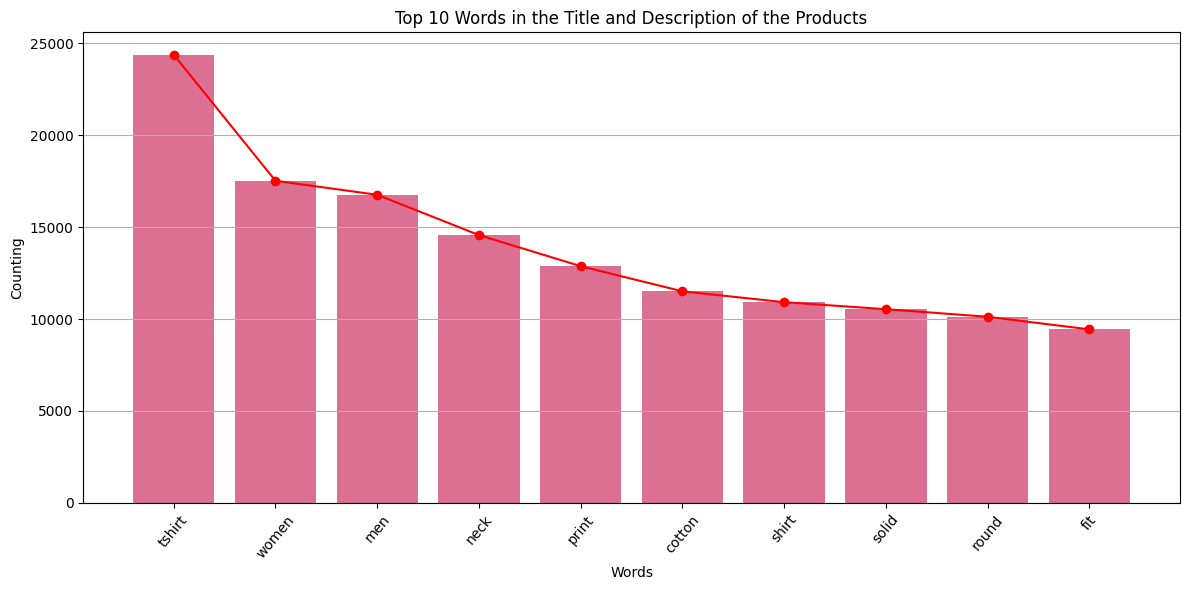

In [15]:
word_ocurrences = word_count(fashion_df_processed, ["title", "description"])
plot_top_10(word_ocurrences, "Words in the Title and Description of the Products", "Words", "Counting", "palevioletred")

#### 2.2. Average Sequence Length and Vocabulary Size

In [17]:
# Function to compute the average length of the text in a particular field
def avg_length(df, field):
  sum = 0
  for doc_id, product in df.iterrows(): # For each product registered
    sum += len(product[field]) # Sum the number of tokens
  return sum / df.shape[0]

In [18]:
avg_title_length = avg_length(fashion_df_processed, "title")
avg_description_length = avg_length(fashion_df_processed, "description")
print(f'Average length of the title: {avg_title_length:.2f} words')
print(f'Average length of the description: {avg_description_length:.2f} words')

Average length of the title: 6.05 words
Average length of the description: 18.18 words


In [22]:
print(f'Vocabulary size of the title and description of the products: {len(word_ocurrences)}')
print(f'Average number of unique words per product (considering only title and description): \
{len(word_ocurrences)/fashion_df_processed.shape[0]:.2f}')

Vocabulary size of the title and description of the products: 5778
Average number of unique words per product (considering only title and description): 0.21


#### 2.3. Ranking of Products (Subcategories)

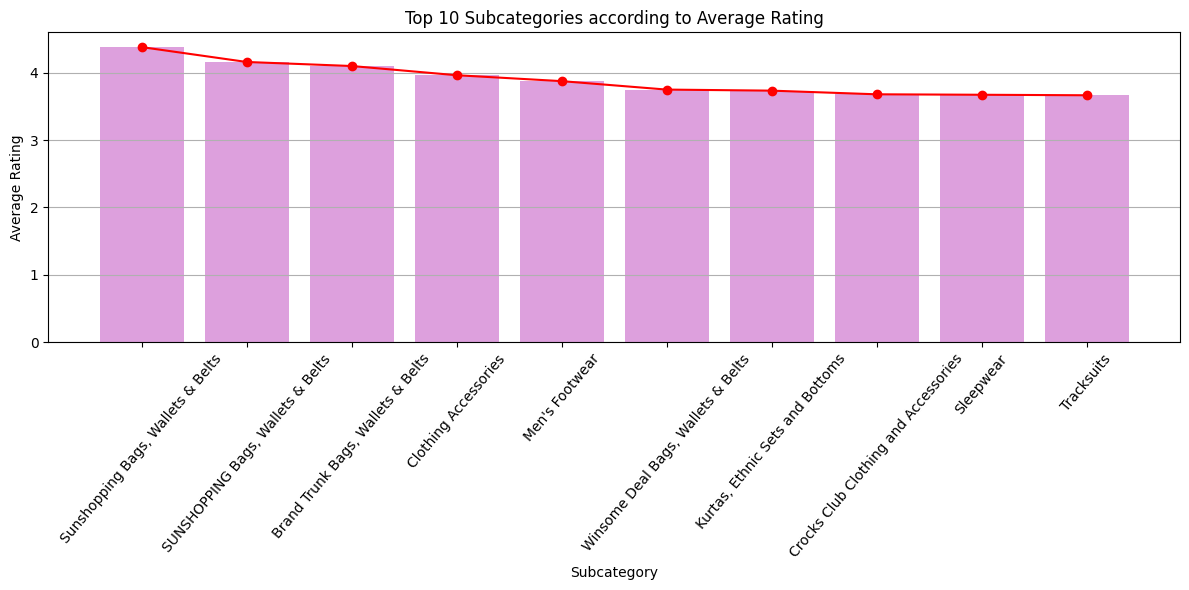

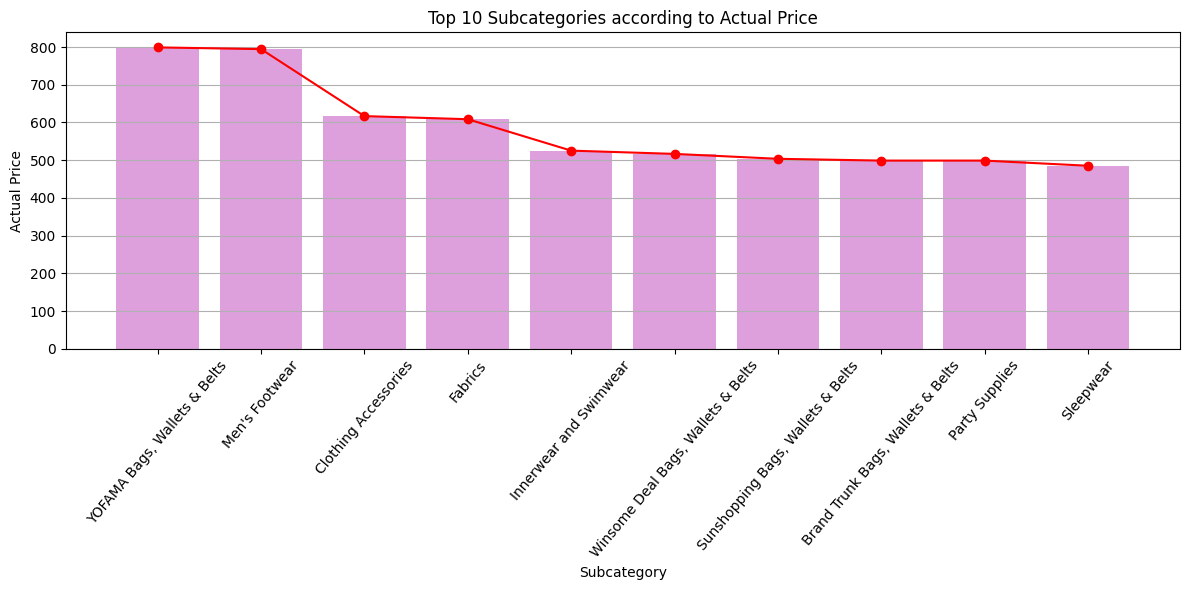

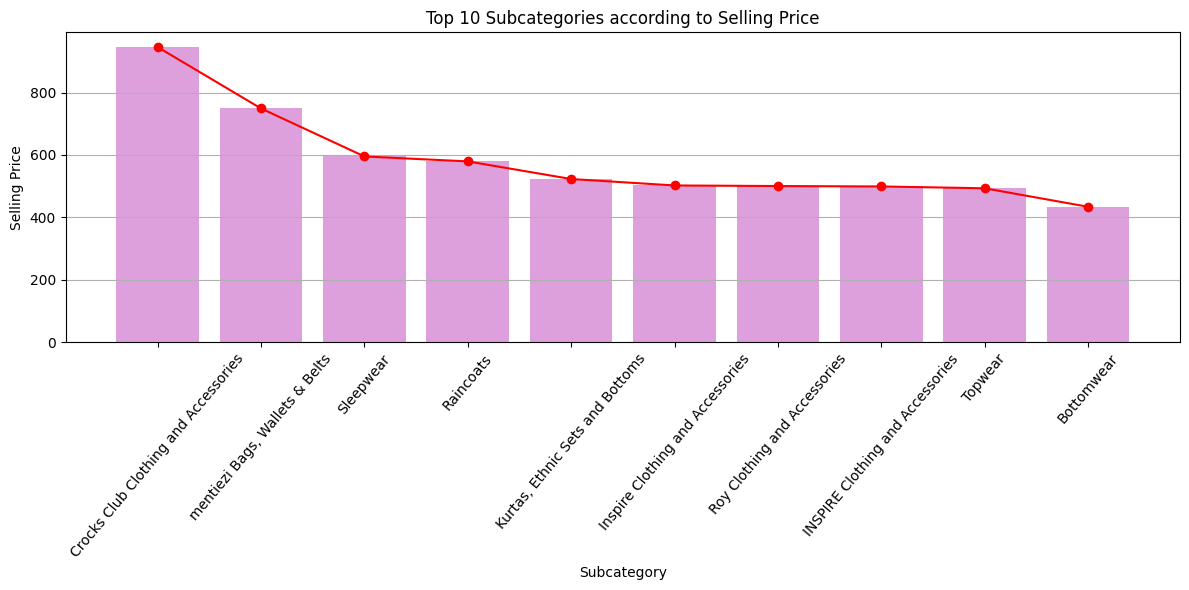

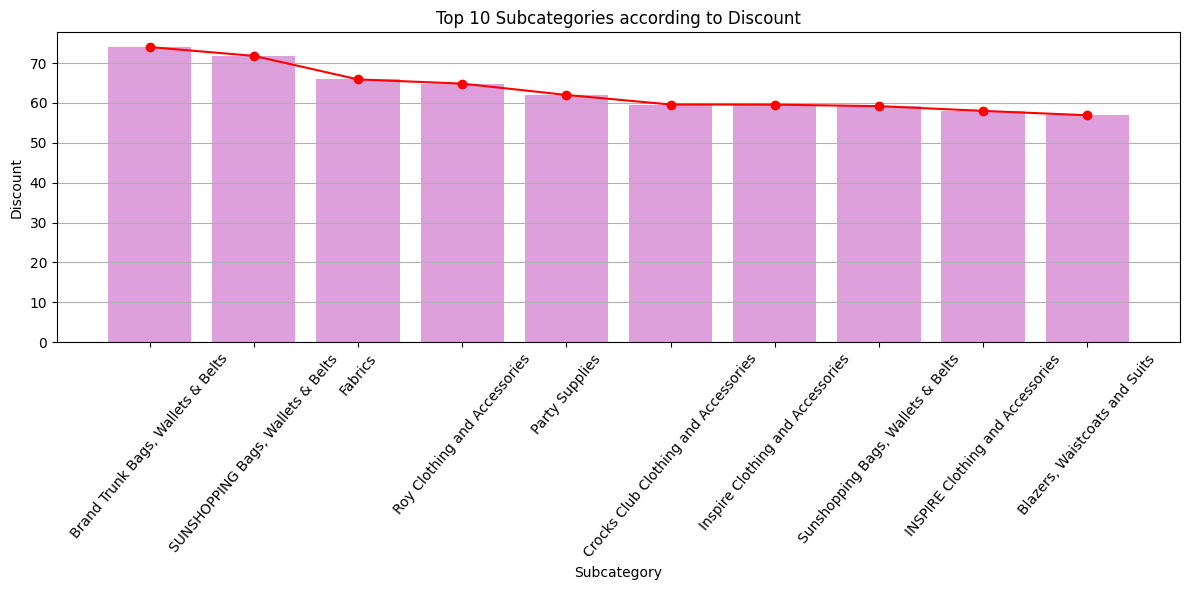

In [24]:
fashion_df_2 = fashion_df.copy()

# Process "average rating" to do the ranking of best rated products
fashion_df_2 = fashion_df_2[~(fashion_df_2["average_rating"] == "")]
fashion_df_2["average_rating"] = fashion_df_2["average_rating"].dropna().astype(float)

# Process "actual price" and "selling price" to do the ranking of most expensive products
fashion_df_2 = fashion_df_2[~(fashion_df_2["actual_price"] == "")]
fashion_df_2["actual_price"] = fashion_df_2["actual_price"].str.replace(",", ".").astype(float)
fashion_df_2 = fashion_df_2[~(fashion_df_2["selling_price"] == "")]
fashion_df_2["selling_price"] = fashion_df_2["selling_price"].str.replace(",", ".").astype(float)

# Process "discount" to do the ranking of products with more discount
fashion_df_2 = fashion_df_2[~(fashion_df_2["discount"] == "")]
fashion_df_2["discount"] = fashion_df_2["discount"].str.replace("%", "") .str.replace("off", "").str.strip().astype(float)

# Show the plots
for column in ["average_rating", "actual_price", "selling_price", "discount"]:
  column_name = column.replace('_', ' ').title()
  top_ranking = fashion_df_2.groupby("sub_category")[column].mean().sort_values(ascending=False).to_dict()
  plot_top_10(top_ranking, f"Subcategories according to {column_name}", "Subcategory", column_name, "plum")

#### 2.4. Top Brands and Sellers

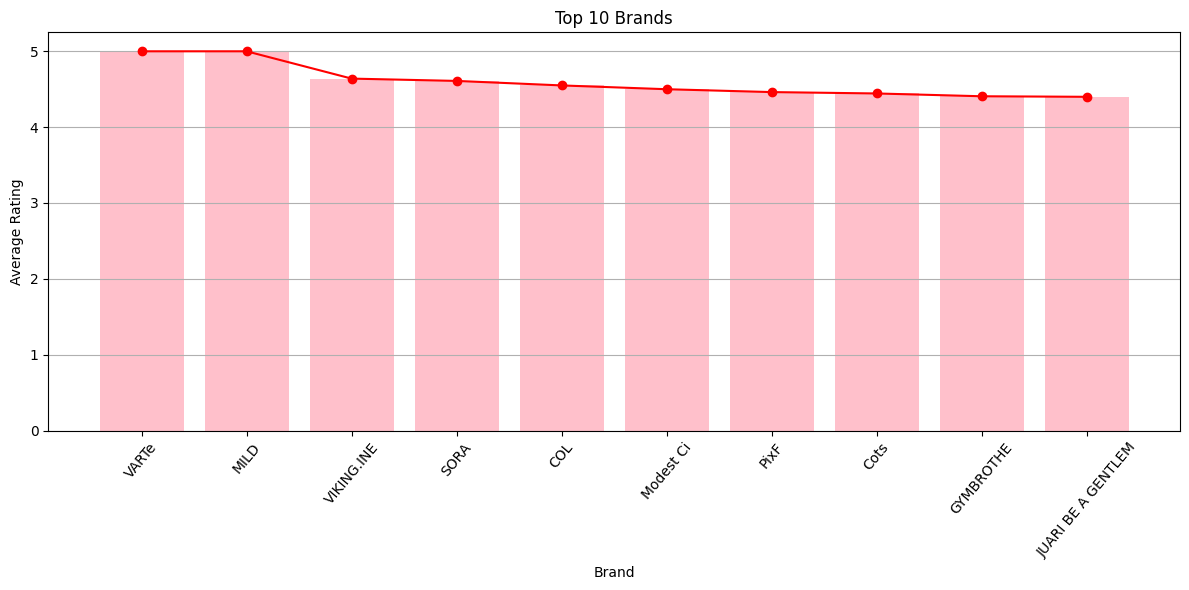

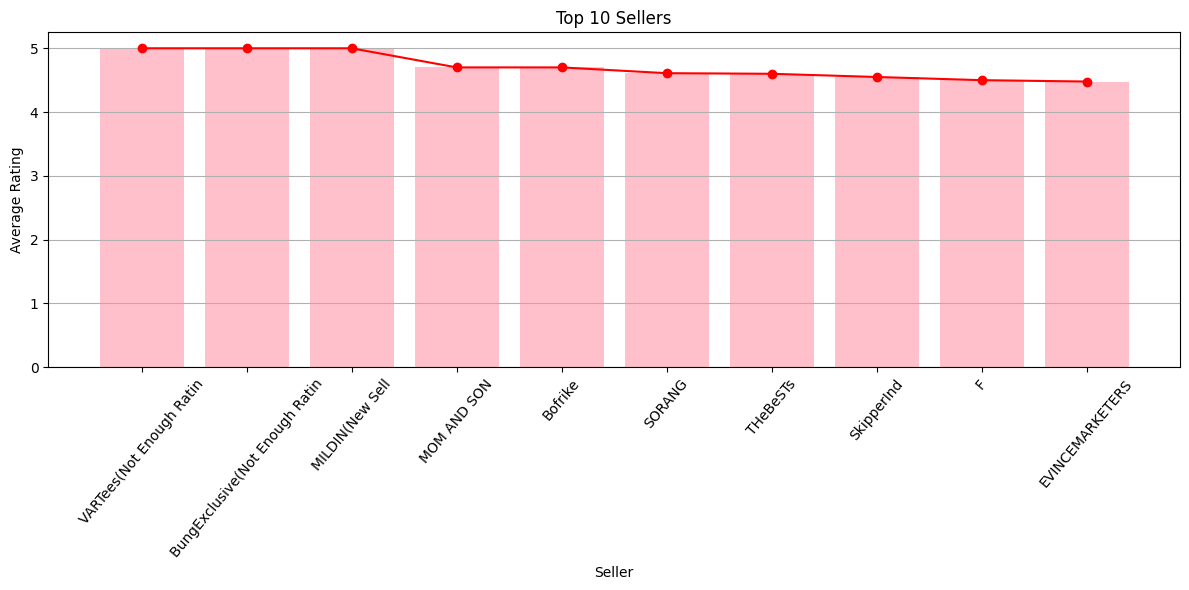

In [25]:
fashion_df_2 = fashion_df.copy()

# Process "average rating" to do the ranking of best rated brands and sellers
fashion_df_2 = fashion_df_2[~(fashion_df_2["average_rating"] == "")]
fashion_df_2["average_rating"] = fashion_df_2["average_rating"].dropna().astype(float)

# Show the plots
for column in ["brand", "seller"]:
  column_name = column.replace('_', ' ').title()
  top_ranking = fashion_df_2.groupby(column)["average_rating"].mean().sort_values(ascending=False).to_dict()
  plot_top_10(top_ranking, f"{column_name}s", column_name, "Average Rating", "pink")

#### 2.5. Out-of-stock Distribution

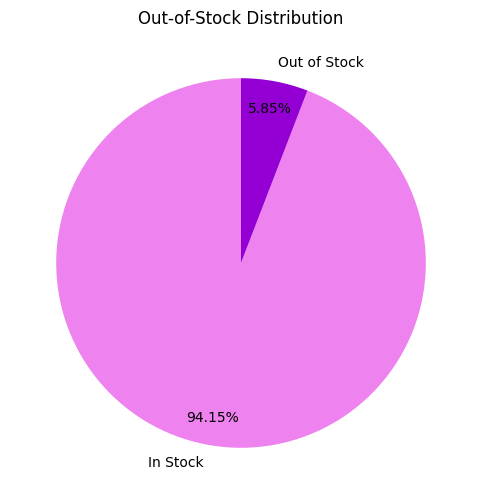

In [36]:
# Count of in-stock vs out-of-stock
stock_counts = fashion_df["out_of_stock"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(stock_counts,  # Number of times of each value (True and False)
        labels=["In Stock", "Out of Stock"], # True = In Stock, False = Out of Stock
        autopct="%1.2f%%", # Format of the percentage (only 2 decimals)
        pctdistance=0.85, startangle=90, # Position of the numbers in the pie and the different wedges
        colors=["violet", "darkviolet"])

plt.title("Out-of-Stock Distribution")
plt.show()

#### 2.6. Word Cloud for Word Counting Distribution

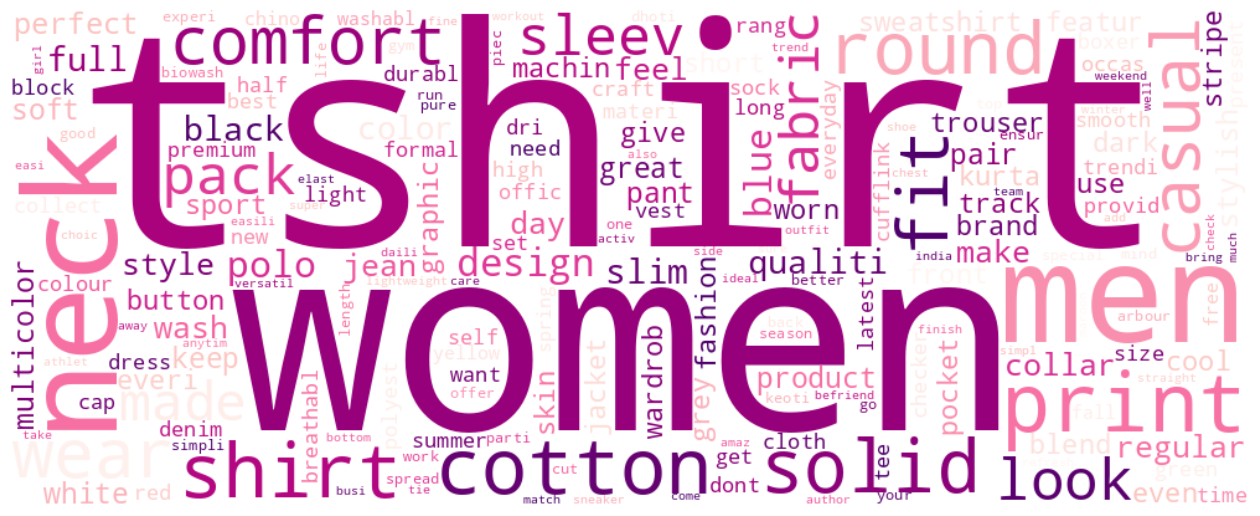

In [35]:
# Generate word cloud based on the word counting distribution previously computed
fashion_wordcloud = WordCloud(width=1000, height=400, background_color='white', colormap= 'RdPu')
fashion_wordcloud.generate_from_frequencies(dict(word_ocurrences))

# Show the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(fashion_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### 2.7. Entity Recognition

In [ ]:
# Load the English NLP (Natural Language Processing) model
nlp = spacy.load("en_core_web_sm")

# Consider only the titles of the products
title_data = fashion_df["title"].dropna().unique()
titles = " ".join(title_data)

# Process all titles as one unique text
doc = nlp(titles)
entities = [(ent.text, ent.label_) for ent in doc.ents]

# Store results as a dataframe for better visualization
entities_df = pd.DataFrame(entities, columns=["entity", "label"])
entities_df.head(10)

,entity,label
0,Solid Women,PERSON
1,-Lite Satin Tie & Cufflink,ORG
2,Beige,PERSON
3,Brown,PERSON
4,Brown,PERSON
5,Brown Sweater,PERSON
6,Black Sweater Solid Men Raincoat Self Design M...,ORG
7,2,CARDINAL
8,Solid Men Polo Neck Red,PERSON
9,Grey T-Shirt (Pack of 2,ORG
